In [ ]:
### Created by Suparno Bhattacharyya

## Summary of steps

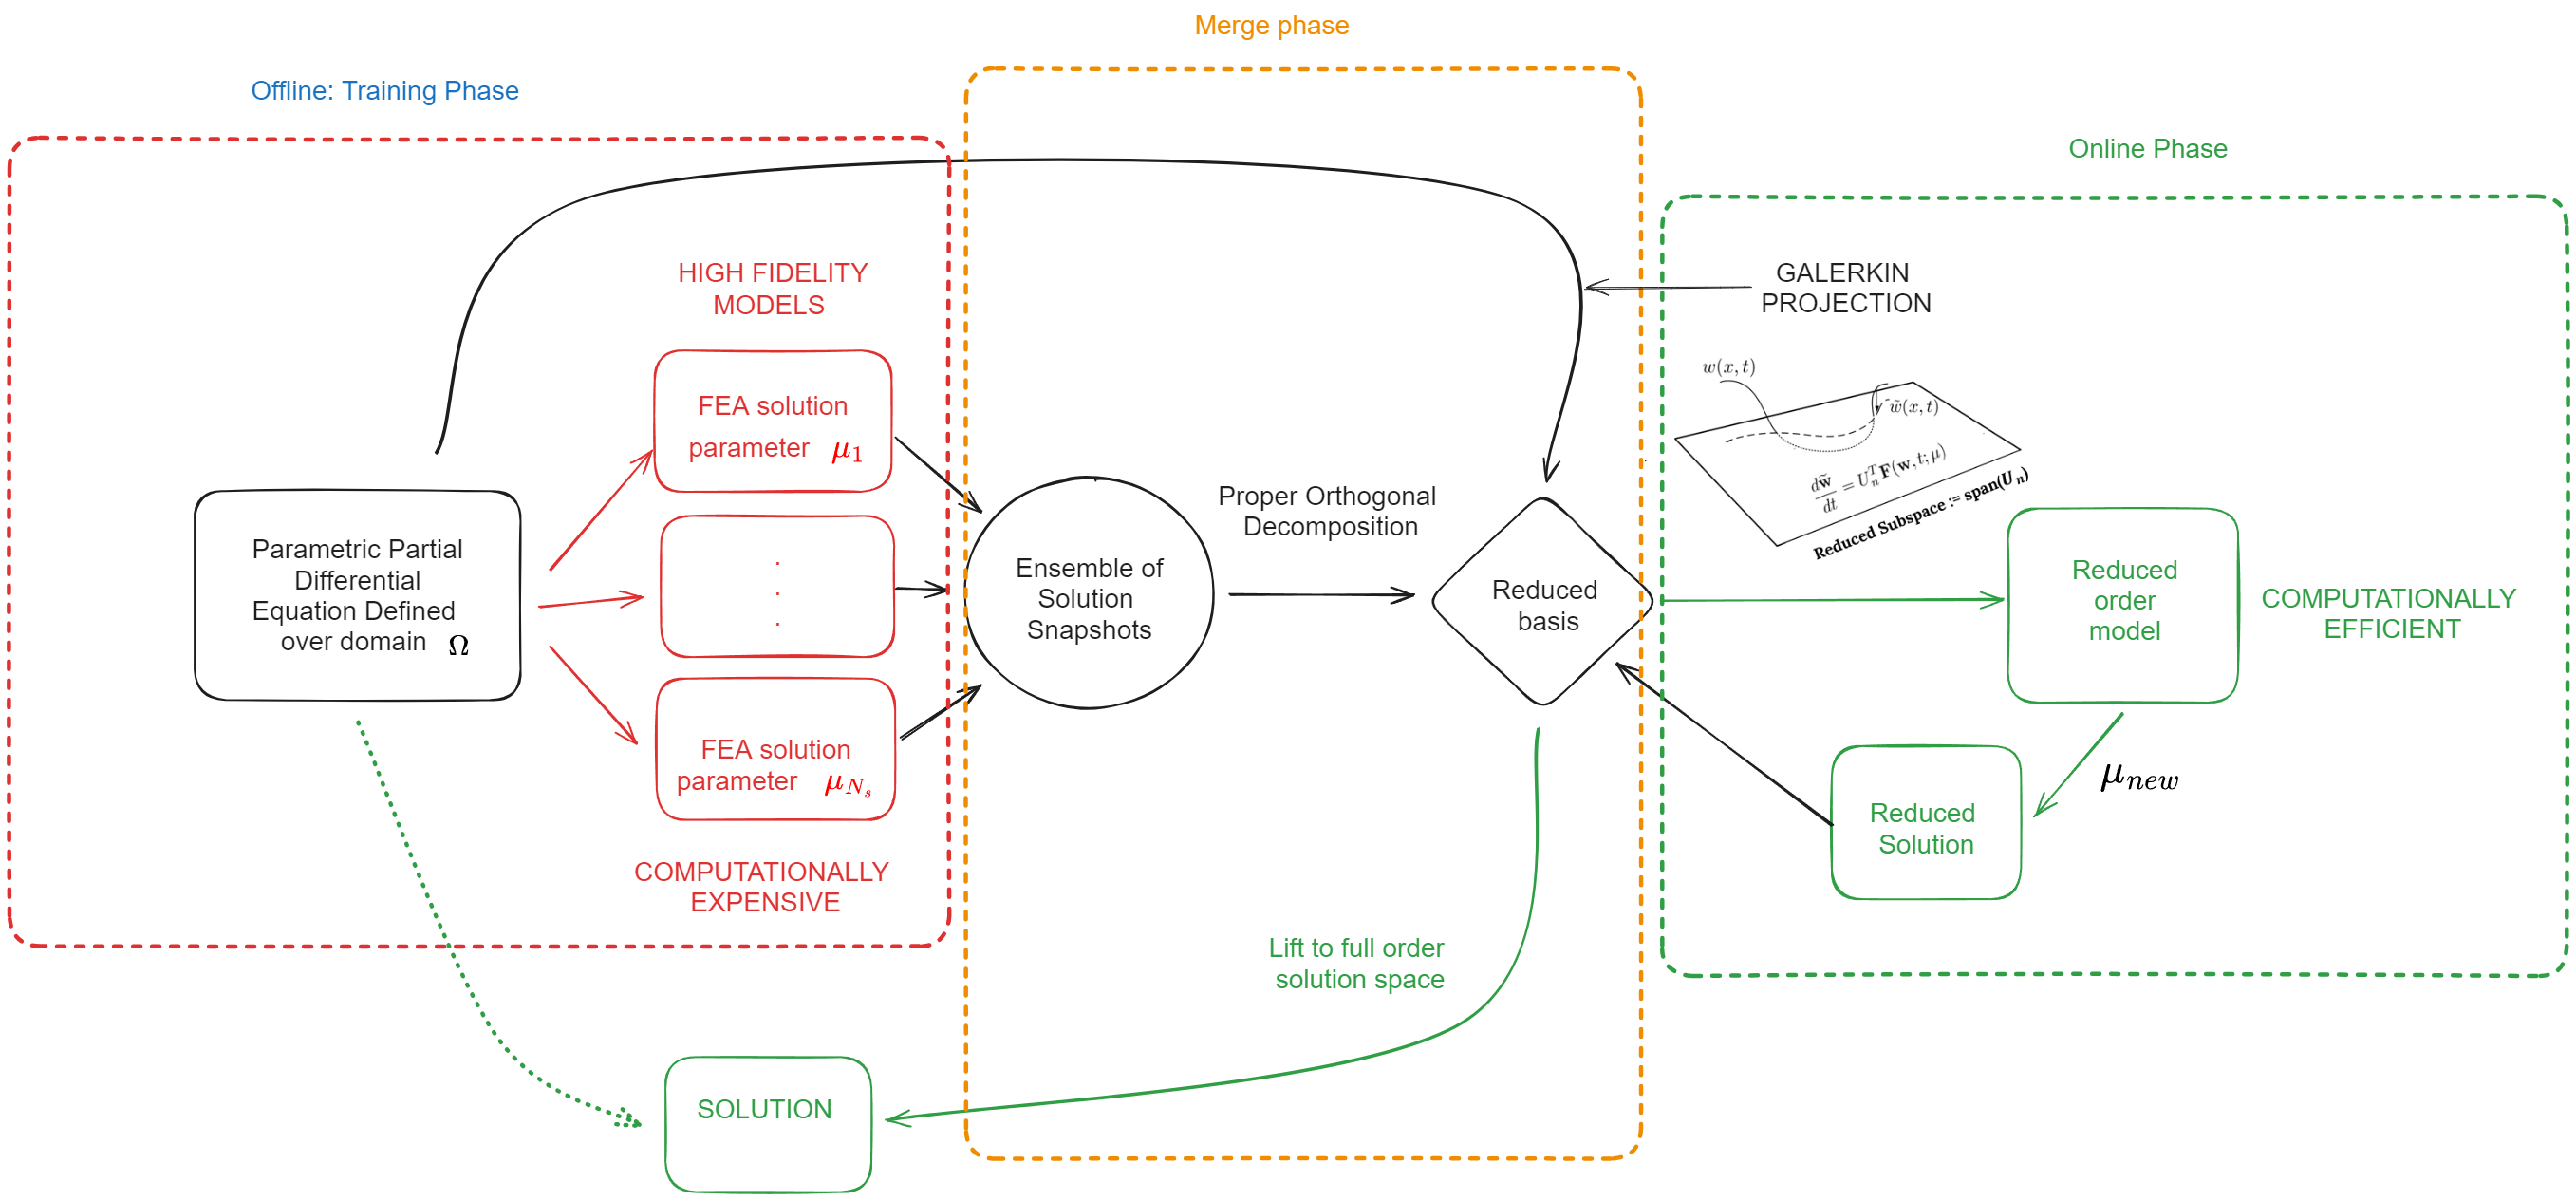

## pylibROM 

In [ ]:
# !pip install papermill
# !pip install matplotlib

In [ ]:
import tempfile
import shutil
import os
from stopwatch import StopWatch
import numpy as np
from rom_utils import train_test_split

In [ ]:
# Execute the notebook with updated parameters
N_snap = 50
freq = np.linspace(1.,5.,N_snap)
freq_id = np.r_[0:len(freq)]
phase = 1
random_seed = 42
train_percentage = 0.65
training_set, test_set = train_test_split(N_snap, train_percentage = train_percentage, seed = random_seed)


In [ ]:
rom_data_dir = "rom_data/"
train_data_dir = "training_data/"

In [ ]:
def delete_folder(folder_path):
    """
    Deletes a folder and all its contents.

    Parameters:
    - folder_path: str, the path to the folder to be deleted.

    Returns:
    - None
    """
    try:
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)
            print(f"Successfully deleted the folder: {folder_path}")
        else:
            print(f"The folder does not exist: {folder_path}")
    except Exception as e:
        print(f"An error occurred while deleting the folder: {e}")

delete_folder(rom_data_dir)
delete_folder(train_data_dir)

### Offline Training Phase


In [ ]:
traning_params = freq[training_set]
training_freq_id = freq_id[training_set].tolist()

In [ ]:
import subprocess
import time

max_retries = 3  # Maximum number of retries for a failed execution

for id in range(len(traning_params)):
    retry_count = 0
    while retry_count <= max_retries:
        with tempfile.NamedTemporaryFile(suffix=".ipynb", delete=True) as tmp:
            output_notebook_path = tmp.name

            # Construct the command
            cmd = ['papermill', 'Data_Generation.ipynb', output_notebook_path,
                   '-p', 'frequency', str(float(traning_params[id])),
                   '-p', 'id', str(training_freq_id[id]),
                   '-p', 'phase', str(phase)]

            # Execute the command in a subprocess
            result = subprocess.run(cmd, capture_output=True, text=True)

            # Check if the execution was successful
            if result.returncode == 0:
                print(f"Successfully executed notebook for id {id}.")
                break  # Exit the retry loop if successful
            else:
                retry_count += 1
                print(f"Attempt {retry_count} failed for id {id}: {result.stderr}")
                if retry_count > max_retries:
                    print(f"Max retries reached for id {id}. Moving on...")
                else:
                    print(f"Retrying for freq {traning_params[id]}, id {training_freq_id[id]}...")
                    time.sleep(1)  # Optional: sleep between retries to mitigate potential transient issues

### Test Data

In [ ]:
test_params = freq[test_set]
test_freq_id = freq_id[test_set].tolist()
phase = 0

In [ ]:
import subprocess
import time

max_retries = 3  # Maximum number of retries for a failed execution

for id in range(len(test_params)):
    retry_count = 0
    while retry_count <= max_retries:
        with tempfile.NamedTemporaryFile(suffix=".ipynb", delete=True) as tmp:
            output_notebook_path = tmp.name

            # Construct the command
            cmd = ['papermill', 'Data_Generation.ipynb', output_notebook_path,
                   '-p', 'frequency', str(float(test_params[id])),
                   '-p', 'id', str(test_freq_id[id]),
                   '-p', 'phase', str(phase)]

            # Execute the command in a subprocess
            result = subprocess.run(cmd, capture_output=True, text=True)

            # Check if the execution was successful
            if result.returncode == 0:
                print(f"Successfully executed notebook for id {id}.")
                break  # Exit the retry loop if successful
            else:
                retry_count += 1
                print(f"Attempt {retry_count} failed for id {id}: {result.stderr}")
                if retry_count > max_retries:
                    print(f"Max retries reached for id {id}. Moving on...")
                else:
                    print(f"Retrying for id {id}...")
                    time.sleep(1)  # Optional: sleep between retries to mitigate potential transient issues

## ROM 

In [ ]:
import papermill as pm

##### Merge Phase

In [ ]:
with tempfile.NamedTemporaryFile(suffix=".ipynb", delete=True) as tmp:
    pm.execute_notebook(
        'ROM_merge.ipynb',
        tmp.name,
        parameters={'ns':len(training_freq_id),'train_freq_id':training_freq_id}
    )

#### Online Phase [Solve ROM for test parameters] 

In [ ]:
for id in range(len(test_params)):
    retry_count = 0
    while retry_count <= max_retries:
        with tempfile.NamedTemporaryFile(suffix=".ipynb", delete=True) as tmp:
            output_notebook_path = tmp.name

            # Construct the command
            cmd = ['papermill', 'ROM_ONLINE.ipynb', output_notebook_path,
                   '-p', 'frequency', str(float(test_params[id])),
                   '-p', 'id', str(test_freq_id[id])]

            # Execute the command in a subprocess
            result = subprocess.run(cmd, capture_output=True, text=True)

            # Check if the execution was successful
            if result.returncode == 0:
                print(f"Successfully executed notebook for id {id}.")
                break  # Exit the retry loop if successful
            else:
                retry_count += 1
                print(f"Attempt {retry_count} failed for id {id}: {result.stderr}")
                if retry_count > max_retries:
                    print(f"Max retries reached for id {id}. Moving on...")
                else:
                    print(f"Retrying for id {id}...")
                    time.sleep(1)  # Optional: sleep between retries to mitigate potential transient issues

## Performance Statistics for ROMs

#### Retrieve Data

In [ ]:
# Define a function to read the times from the file
filename_FOM = rom_data_dir+'Assemble_solve_FOM_log.csv'
filename_ROM = rom_data_dir+'Assemble_solve_ROM_log.csv'

In [ ]:
def read_FOM_data(filename):
    data = {'FOM': {'Assemble': [], 'Solve': []}}

    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            model_type, stage, duration = parts[0], parts[1], float(parts[2])
            data[model_type][stage].append(duration)
    
    return data


def read_ROM_data(filename):
    data = {'ROM': {'Assemble': [], 'Solve': [], 'Accuracy': []}}
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            model_type, stage, duration = parts[0], parts[1], float(parts[2])
            data[model_type][stage].append(duration)
    
    return data


data_FOM = read_FOM_data(filename_FOM)
data_ROM = read_ROM_data(filename_ROM)

In [ ]:
Assemble_speedup = np.array(data_FOM['FOM']['Assemble'])/np.array(data_ROM['ROM']['Assemble'])
Sol_speedup = np.array(data_FOM['FOM']['Solve'])/(np.array(data_ROM['ROM']['Solve']))
ROM_accracy = data_ROM['ROM']['Accuracy']

#### Plot Data

In [ ]:
# !pip install pandas
# !pip install ptitprince

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ptitprince as pt

In [ ]:
df_Assemble_speedup = pd.DataFrame({'':'','Assembly speed-up':Assemble_speedup})
df_sol_speed = pd.DataFrame({'':'','Solution speed-up (log)':np.log10(Sol_speedup)})
df_accuracy = pd.DataFrame({'':'','Relative error (log)':np.log10(ROM_accracy)})
Merge_time = np.load(rom_data_dir+'merge_time.npy')

In [ ]:
fig, ax = plt.subplots(figsize=(8.3, 3))
pt.RainCloud(x = '', y = 'Assembly speed-up', data = df_Assemble_speedup, palette = "Oranges", bw = 0.2,
    width_viol = 1., ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.35, linewidth=1, point_size =2.0, move=0.2)
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
pt.RainCloud(x = '', y = 'Solution speed-up (log)', data = df_sol_speed, palette = "viridis", bw = 0.2,
    width_viol = 1., ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.35, linewidth=1, point_size =2.0, move=0.2)
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
pt.RainCloud(x = '', y = 'Relative error (log)', data = df_accuracy, palette = "magma", bw = 0.2,
    width_viol = 1., ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.35, linewidth=1, point_size =2.0, move=0.2)
plt.show()